In [268]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from irf.ensemble import wrf
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

# Compare different methods in terms of feature selection using simulated data

In [ ]:
### load data

num = 2

problem = [0]
tree_depth = [1]
for num in range(1, 3):
    for problem in ['classification', 'regression']:
        for tree_depth in ['deep', 'shallow']:
            print('working on {} {} {}'.format(num, problem, tree_depth))
            oob_list, gini_list, shap_list, mda_list = [], [], [], []
            for i in range(40):
                X_train = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_X_train.csv'.format(problem, num, i), delimiter=',')
                y_train = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_y_train.csv'.format(problem, num, i), delimiter=',')
                X_test = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_X_test.csv'.format(problem, num, i), delimiter=',')
                y_test = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_y_test.csv'.format(problem, num, i), delimiter=',')
                noisy_features = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_noisy_features.csv'.format(problem, num, i), delimiter=',').astype(np.int)
                n_features = len(noisy_features)

                ### Train RF
                if problem == 'classification':
                    if tree_depth == 'deep':
                        rf = rfc(n_estimators=100, max_features=10, min_samples_leaf=1)
                    else:
                        rf = rfc(n_estimators=100, max_features=10, min_samples_leaf=100)
                else:
                    if tree_depth == 'deep':
                        rf = rfr(n_estimators=100, max_features= 10, min_samples_leaf=1)
                    else:
                        rf = rfr(n_estimators=100, max_features= 10, min_samples_leaf=100)
                rf.fit(X_train, y_train)
                gini_imp = rf.feature_importances_
                if problem == 'classification':
                    y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()
                    oob_imp, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False, balanced = False)
                else:
                    oob_imp, debiased_fi_std = FI(rf, X_train, y_train[:, np.newaxis], type='oob', normalized=False, balanced = False)

                if problem == 'classification':
                    MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=5)
                else:
                    MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=5, metric='mse')

                explainer = shap.TreeExplainer(rf)
                samples = np.random.choice(range(X_train.shape[0]), 100)
                shap_values = explainer.shap_values(X_train[samples, :])
                #shap_values = explainer.shap_values(X_train)
                if problem == 'classification':
                    shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
                else:
                    shap_imp = np.mean(abs(shap_values), 0) 

                ### Comparison

                oob_imp[oob_imp < 0] = 0
                MDA_imp[MDA_imp < 0] = 0
                oob_list.append(roc_auc_score(noisy_features, - oob_imp))
                gini_list.append(roc_auc_score(noisy_features, - gini_imp))
                shap_list.append(roc_auc_score(noisy_features, - shap_imp))
                mda_list.append(roc_auc_score(noisy_features, - MDA_imp))

            np.savez('../intermediate/04_aggregate/{}{}/new_results_{}.npz'.format(problem, num, tree_depth), debiased_list = oob_list, gini_list=gini_list, shap_list=shap_list, mda_list=mda_list)


working on 1 classification deep


/home/ubuntu/github/treeinterpreter/treeinterpreter/feature_importance.py:23: RuntimeWarning: invalid value encountered in double_scalars
  permute_std = (permute_std - permute_score ** 2) ** .5 / n_trials ** .5


working on 1 classification shallow


/home/ubuntu/github/treeinterpreter/treeinterpreter/feature_importance.py:23: RuntimeWarning: invalid value encountered in double_scalars
  permute_std = (permute_std - permute_score ** 2) ** .5 / n_trials ** .5
/home/ubuntu/github/treeinterpreter/treeinterpreter/feature_importance.py:23: RuntimeWarning: invalid value encountered in double_scalars
  permute_std = (permute_std - permute_score ** 2) ** .5 / n_trials ** .5
/home/ubuntu/github/treeinterpreter/treeinterpreter/feature_importance.py:23: RuntimeWarning: invalid value encountered in double_scalars
  permute_std = (permute_std - permute_score ** 2) ** .5 / n_trials ** .5


working on 1 regression deep


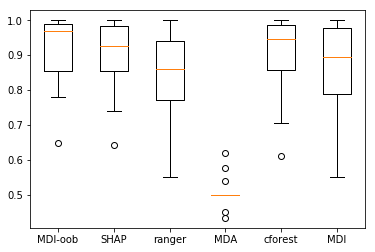

[0.896      0.79466667 0.71333333 1.         0.94133333 0.70666667
 0.60133333 0.896      1.         0.97333333 0.712      0.98666667
 0.99733333 0.97866667 0.98133333 0.86666667 0.91733333 0.87733333
 0.944      0.864      0.73333333 0.772      0.552      0.91466667
 0.99466667 0.97866667 0.89066667 1.         0.99733333 0.83466667
 0.84266667 0.92533333 0.84533333 0.97333333 0.84       0.752
 0.74133333 0.85333333 1.         0.74933333]
[0.81066667 0.664      0.61333333 0.96533333 0.90666667 0.64266667
 0.53333333 0.77333333 0.90933333 0.81333333 0.55733333 0.92533333
 0.92       0.84       0.80533333 0.86133333 0.91466667 0.74666667
 0.83733333 0.75466667 0.77066667 0.66133333 0.696      0.696
 0.872      0.728      0.72       0.968      0.87466667 0.39733333
 0.78933333 0.89333333 0.68       0.90133333 0.77866667 0.584
 0.608      0.68266667 0.77866667 0.512     ]


In [496]:
problem = 'classification'
num = 1
tree_depth = 'shallow'
tmp = np.load('../intermediate/04_aggregate/{}{}/new_results_{}.npz'.format(problem, num, tree_depth))
debiased, gini, SHAP, mda = [tmp[x] for x in list(tmp)]
tmp2 = pd.read_csv('../intermediate/04_aggregate_R/auc_df_{}{}_{}.csv'.format(problem, num, tree_depth))
gini_R, ranger, cforest = np.array(tmp2.iloc[:, 1]), np.array(tmp2.iloc[:, 2]), np.array(tmp2.iloc[:, 3])
gini_R, ranger, cforest
out = np.array([debiased, SHAP,ranger, mda, cforest, gini]).T
plt.boxplot(out)
plt.xticks(list(range(1, 7)), ['MDI-oob', 'SHAP', 'ranger', 'MDA', 'cforest', 'MDI'])
plt.show()
print(gini)
print(gini_R)

In [497]:
print(' ')
[print('{:.3f}'.format(x)) for x in np.mean(out,0)]
print(' ')

 
0.924
0.902
0.853
0.503
0.913
0.871
 


In [397]:
gini

array([0.704     , 0.55466667, 0.60533333, 0.872     , 0.81066667,
       0.584     , 0.408     , 0.66666667, 0.46666667, 0.632     ,
       0.33066667, 0.76533333, 0.73333333, 0.688     , 0.61333333,
       0.84533333, 0.576     , 0.568     , 0.70133333, 0.62933333,
       0.69333333, 0.50933333, 0.304     , 0.624     , 0.71733333,
       0.616     , 0.54933333, 0.72      , 0.808     , 0.34933333,
       0.688     , 0.704     , 0.52      , 0.66933333, 0.48      ,
       0.24533333, 0.46933333, 0.53066667, 0.54133333, 0.38133333,
       0.93066667, 0.808     , 0.69733333, 1.        , 0.97333333,
       0.71733333, 0.54666667, 0.792     , 1.        , 0.976     ,
       0.664     , 0.98666667, 0.99466667, 0.984     , 0.97866667,
       0.872     , 0.92533333, 0.94133333, 0.99466667, 0.82666667,
       0.768     , 0.78666667, 0.48533333, 0.888     , 0.98133333,
       0.91466667, 0.968     , 0.99733333, 0.976     , 0.93333333,
       0.864     , 0.968     , 0.904     , 0.984     , 0.90666